# Encryption
 
We can use ngram models for solving (simple) substitution encryption. A substitution crypto is an encrypted message where each symbol (in this case characters) has been substituted with some other symbol. This follows from our ability to evaluate the probability of a character sequence. By training a character ngram model on (in this case) english text, we can guess an encryption key, decrypt a message, and then evaluate a probability. By changing the key slightly, we can evaluate if the probability of our result is english has increased. By this method we will slowly work our way toward a solution. This is a slow process and not very well suited for human labour. The problem formulation is, however, very well suited for a computer.

We'll start by downloading some reference text to use for training the model.

In [1]:
# Download reference text
import nltk
nltk.download('gutenberg')

# These are some books in the collection of the gutenberg project
books = ['carroll-alice.txt', 'melville-moby_dick.txt', 'milton-paradise.txt',  
         'austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt']
#books = ['carroll-alice.txt']
# books = ['austen-emma.txt']

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


We can create a vocabulary from the corpus. This might be usefull for evaluating performance after having found a resonable decryption key.

In [2]:
vocabulary = set(nltk.corpus.gutenberg.words(books))
vocabulary = set([word.lower() for word in vocabulary])
print("Created a lower case vocabulary with %i entries" % len(vocabulary))

Created a lower case vocabulary with 24570 entries


We can now load the raw data and see what it looks like.

In [3]:
raw_text = nltk.corpus.gutenberg.raw(books)
print(raw_text[:500])

[Alice's Adventures in Wonderland by Lewis Carroll 1865]

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversation?'

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy an


To make our likes easier, we define an allowed character (i.e. a constrained character set). This is so we don't have to care about special characters in this example.

In [4]:
# Define an allowed character set for the pre-processing
character_set = set('abcdefghijklmnopqrstuvwxyz -.,:')

Pre-processing of the training data to make printouts in this notebook a bit more clear and to reduce code complexity slightly.

In [5]:
# I will pre-process the text for simplicity
def pre_process(unprocessed_text):
  # Force lower case
  unprocessed_text = unprocessed_text.lower()
  # Restrict character set
  old_character_set = "".join(set(list(unprocessed_text)))
  new_character_set = "".join([c if c in character_set else " " for c in old_character_set])
  text = unprocessed_text.translate(str.maketrans(old_character_set, new_character_set))
  # Remove multiple spaces and return
  import re
  return re.sub("\s\s+" , " ", text.strip())

# Call the pre-processing for the 
training_data = pre_process(raw_text)

This is what the pre-processed text looks like

In [6]:
print(training_data[:300])

alice s adventures in wonderland by lewis carroll chapter i. down the rabbit-hole alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it,


This is a naive character ngram model. Most of the time one should use a more tested class from som NLP library. However, the code here is included to show you how short the code can be.

In [7]:
import numpy as np # Math library

class NaiveCharacterNGram(object):
  def __init__(self, order=1):
    """
    Naive NGram counter

    Assumes that all characters can be found in the training set.
    """
    assert order >= 1
    self.order_ = order
    self.counts_ = dict()

  def _tokeniser(self, X, order, limit=-1):
    """
    Internal tokeniser

    X: text data
    order: order if the character tokens
    limit: max number of tokens to output (unlimited if <1)
    """
    if limit < 1:
      limit = len(X)-order+1
    for i in range(limit):
      yield X[i:i+order]

  def fit(self, X):
    """
    Train the model

    X: text data
    """
    assert type(X) == str
    self._probability_lut = dict()
    for order in range(1, self.order_+1):
      for ngram in self._tokeniser(X, order):
        if ngram not in self.counts_.keys():
          self.counts_[ngram] = 1
        else:
          self.counts_[ngram] += 1
    self.unigram_total_ = np.sum([self.counts_[ngram] for ngram in self.counts_.keys() if len(ngram) == 1])
    return self

  def _P(self, ngram):
    """
    Internal method for getting the probability of a single ngram
    """
    # Check if the ngram is in the internal look up table (LUT)
    if ngram in self._probability_lut.keys():
      return self._probability_lut[ngram]
    else:
      # Calculate the probability
      assert 0 < len(ngram) <= self.order_, "The model only supports ngram with length 0 < len <= %i" % self.order_
      # Check if this ngram was present in the training data
      if ngram in self.counts_.keys():
        if len(ngram) == 1:
          p = np.log(self.counts_[ngram] / self.unigram_total_)
        else:
          contitional_ngram = ngram[1:]
          p = np.log(self.counts_[ngram] / self.counts_[contitional_ngram])
      else:
        # Fallback is the model had not seen this ngram before
        p = np.min([model._P(k) for k in model.counts_.keys() if len(k) == len(ngram)]) - np.log(2)
      self._probability_lut[ngram] = p # Store the calculations for the future
      return p

  def predict_proba(self, X):
    """
    Predicts the probability of a text string under the model.

    X: text data
    Returns log probability
    """
    ngrams = list(self._tokeniser(X, self.order_))
    if self.order_ > 1:
      for order in range(1, self.order_+1):
        ngrams.extend(self._tokeniser(X, order, limit=1))
    p = 0
    for ngram in ngrams:
      p += model._P(ngram)
    return p

# Make a model and test it
model = NaiveCharacterNGram(order=1).fit(training_data)
assert np.isclose(model.predict_proba('acb'), model.predict_proba('abc'))

# A higher order model
model = NaiveCharacterNGram(order=3).fit(training_data)
model.predict_proba('alice')

-14.017937498823205

We can now evaluate sentences under the trained model.

$P(\text{"I am not good at spelling"} | model)$

In [8]:
model.predict_proba("I am not good at spelling")

-87.4429702131386

In [9]:
model.predict_proba("spleling")

-26.005396467210918

In [10]:
model.predict_proba("spelling")

-20.014447326269273

In [11]:
unigram_model = NaiveCharacterNGram(order=1).fit(training_data)
bigram_model = NaiveCharacterNGram(order=2).fit(training_data)
trigram_model = NaiveCharacterNGram(order=3).fit(training_data)
#quadgram_model = NaiveCharacterNGram(order=4).fit(training_data) # Quadgram is buggy, fix this in the future!

In [12]:
print("Unigram", unigram_model.predict_proba("I am not good at spelling"))
print("Bigram", bigram_model.predict_proba("I am not good at spelling"))
print("Trigram", trigram_model.predict_proba("I am not good at spelling"))
#print("Quadgram", quadgram_model.predict_proba("I am not good at spelling")) # Quadgram is buggy, fix this in the future!

Unigram -77.14799973232988
Bigram -89.43303052287294
Trigram -87.4429702131386


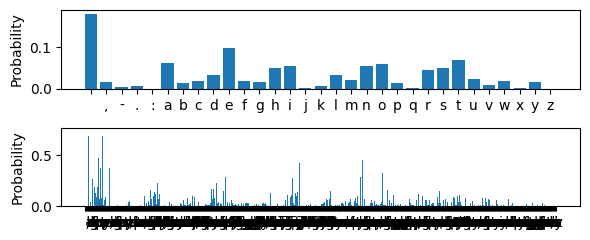

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 2.5), dpi=100)
ax = fig.subplots(2, 1)

symbols = list(set([k for k in model.counts_.keys() if len(k)==1]))
symbols.sort()
prob = np.exp([model._P(s) for s in symbols])
ax[0].bar(symbols, prob)
ax[0].set_ylabel("Probability")

symbols = list(set([k for k in model.counts_.keys() if len(k)==2]))
symbols.sort()
prob = np.exp([model._P(s) for s in symbols])
ax[1].bar(symbols, prob)
ax[1].set_ylabel("Probability")

fig.tight_layout()
fig.show()

## Load poem

### Poem 1

In [ ]:
!wget -N https://raw.githubusercontent.com/fredrikwahlberg/5LN445/master/poem1.txt

with open('poem1.txt', 'r') as f:
  encrypted_text = f.read()

print("Encrypted text:", encrypted_text[:100], "...")

### Poem 2

In [ ]:
!wget -N https://raw.githubusercontent.com/fredrikwahlberg/5LN445/master/poem2.txt

with open('poem2.txt', 'r') as f:
  encrypted_text = f.read()

print("Encrypted text:", encrypted_text[:100], "...")

### Poem 3

In [ ]:
!wget -N https://raw.githubusercontent.com/fredrikwahlberg/5LN445/master/poem3.txt

with open('poem3.txt', 'r') as f:
  encrypted_text = f.read()

print("Encrypted text:", encrypted_text[:100], "...")

### Poem 4

In [ ]:
!wget -N https://raw.githubusercontent.com/fredrikwahlberg/5LN445/master/poem4.txt

with open('poem4.txt', 'r') as f:
  encrypted_text = f.read()

print("Encrypted text:", encrypted_text[:100], "...")

### Poem 5

In [ ]:
!wget -N https://raw.githubusercontent.com/fredrikwahlberg/5LN445/master/poem5.txt

with open('poem5.txt', 'r') as f:
  encrypted_text = f.read()

print("Encrypted text:", encrypted_text[:100], "...")

Train models to use for evaluating a key


Define the probability meassure using the models. *Note that you can run this cell and redefine P and still go back to a "running" decryption.*


In [ ]:
def P(decrypted_text):
  ret = unigram_model.predict_proba(decrypted_text)
  ret += bigram_model.predict_proba(decrypted_text)
  ret += trigram_model.predict_proba(decrypted_text)
  #ret += quadgram_model.predict_proba(decrypted_text) # Quadgram is buggy, fix this in the future!
  return ret

### Make a new (random) key

In [ ]:
unencoded = "".join(character_set)
encoded = unencoded.upper().translate({ord(' '): ord('0'),
                                       ord('-'): ord('1'),
                                       ord('.'): ord('2'),
                                       ord(','): ord('3'),
                                       ord(':'): ord('4')})
# Split the symbols
symbols = list(encoded)
# Shuffle the symbols
import random
random.shuffle(symbols)
# Join the symbols
encoded = ''.join(symbols)
print("New key")
print("Unencoded:", unencoded)
print("Encoded:  ", encoded)

### Run optimisation

In [ ]:
import time

# Decrypt using scrambled key
key = str.maketrans(encoded, unencoded)
decrypted_text = encrypted_text.translate(key)

p = P(decrypted_text)

print("Initial decrypted text %s" % decrypted_text[:80])
print("P: %f" % p)

msg_time = time.time()
n_words = 0
best_key = None
for i in range(5000):
  # Store the probability and key from the last iteration of the loop
  old_p = p
  old_unencoded = unencoded

  # Randomly swap two charcters in the key
  unencoded = list(unencoded)
  a = random.randint(0, len(unencoded)-1)
  b = random.randint(0, len(unencoded)-1)
  c = unencoded[a]
  unencoded[a] = unencoded[b]
  unencoded[b] = c
  unencoded = "".join(unencoded)

  # Decode the message
  key = str.maketrans(encoded, unencoded)
  decrypted_text = encrypted_text.translate(key)

  # Find the probability of the decrypted text to be english
  p = P(decrypted_text)
  
  # Find the number words that we could find in the vocabulary
  old_n_words = n_words
  n_words = np.sum([word in vocabulary for word in decrypted_text.split()])
  if best_key is None or best_key[1] < n_words:
    best_key = (key.copy(), n_words)

  # Print-out
  if i % 200 == 0 or (time.time()-msg_time)>2:
    msg_time = time.time()
    print("%4i | %s | %.2f | %3i | %s" % (i, decrypted_text[:50], p, n_words, unencoded))

  # Metropolis hastings rejection step
  alpha = p - old_p
  if np.log(random.random()) > alpha or (old_n_words > 20 and n_words < old_n_words//2): # Second condition is experimental
    # Reject candidate
    p = old_p
    unencoded = old_unencoded

### Print the decrypted text 

...with some spaces made into line feeds.

In [ ]:
n = 0
for word in decrypted_text.split():
  if n < 60:
    print(word, end=" ")
    n += len(word)+1
  else:
    print(word, end="\n")
    n = 0

In [ ]:
n = 0
for word in encrypted_text.translate(best_key[0]).split():
  if n < 60:
    print(word, end=" ")
    n += len(word)+1
  else:
    print(word, end="\n")
    n = 0